In [1]:
import os

from openai import AzureOpenAI
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2023-12-01-preview",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )


def generate_embeddings(text, model="text-embedding-ada-002"): 
    return client.embeddings.create(input = [text], model=model).data[0].embedding


def calculate_and_plot(sentences, filename=None):
    # calculate embeddings for all combinations of the sentences
    embeddings = [generate_embeddings(s) for s in sentences]

    # calculate cosine similarity for all combinations of the sentences
    similarity = cosine_similarity(embeddings, embeddings)

    # label the rows and columns with the sentences
    similarity = pd.DataFrame(similarity, columns=sentences, index=sentences)
    
    # plot the similarity matrix as a triangle
    sns.heatmap(similarity, cmap="Blues", annot=True)
    if filename:
        plt.savefig(filename+".png", bbox_inches="tight")
    plt.show()

def calculate_and_short(question, options):
    embedding_for_question = generate_embeddings(question)
    embeddings_for_options = [generate_embeddings(option) for option in options]

    # calculate cosine similarity for the question and all options
    similarity = cosine_similarity([embedding_for_question], embeddings_for_options)
    
    # label the rows and columns with the sentences
    similarity = pd.DataFrame(similarity, columns=options, index=[question])

    # short by similarity
    similarity = similarity.T.sort_values(by=question, ascending=False)

    return similarity


## Embedding

### How embeddings look like?

In [2]:
embedding_for_cat = generate_embeddings("Cat")
print(f'The emedding for cat has {len(embedding_for_cat)} elements and looks like {embedding_for_cat}')

definition_of_cat_merrian_webster =  "a carnivorous mammal (Felis catus) long domesticated and kept as a pet or for catching rats and mice"
embedding_for_cat_mw = generate_embeddings(definition_of_cat_merrian_webster)
print(f'The emedding for the definition of cat has {len(embedding_for_cat_mw)} elements and looks like {embedding_for_cat_mw}')


The emedding for cat has 1536 elements and looks like [-0.008119281381368637, -0.007456901017576456, -0.009771818295121193, -0.024842679500579834, -0.012776429764926434, 0.006579417735338211, -0.0015347421867772937, -0.03783079981803894, -0.01431287918239832, -0.026304014027118683, 0.01708531752228737, 0.046134453266859055, 0.003605534555390477, 0.004278157837688923, -0.0321766659617424, -0.004527403973042965, 0.039469677954912186, 0.00512491213157773, 0.007825648412108421, -0.01563763990998268, -0.023599863052368164, 0.005370744038373232, 0.01494111679494381, -0.011929675936698914, -0.006825249642133713, 0.004486432299017906, 0.012312080711126328, -0.01342515368014574, 0.005555117968469858, 0.0009073587134480476, 0.009819618426263332, -0.016579996794462204, -0.017822813242673874, -0.03919653221964836, -0.029390569776296616, -0.00035786465741693974, 0.011390211060643196, -0.0073886145837605, 0.02059525065124035, -0.013930474407970905, 0.009539643302559853, 0.009771818295121193, -0.0134

### Measuring similarity

How similar is "Cat" to its definition?

In [3]:
similarity = cosine_similarity([embedding_for_cat], [embedding_for_cat_mw])
print(similarity[0])

[0.82444797]


**Discusion point: Is this a good similarity? (remember, cosine similarity goes from 0 to 1)**

Lets try something different. Let's compare cats and dogs.

In [4]:
embedding_for_dog = generate_embeddings("Dog")
similarity = cosine_similarity([embedding_for_cat], [embedding_for_dog])
print(similarity[0])

[0.87939172]


**Discussion point: What is happening?**

What about comparing the definitions of cat and dog?

In [5]:
definition_of_dog_merrian_webster =  "a carnivorous mammal (Canis familiaris) closely related to the gray wolf that has long been domesticated as a pet, occurs in a variety of sizes, colors, and coat types, and is sometimes trained to perform special tasks (such as herding, guarding, or acting as a service animal)"

embedding_for_dog_mw = generate_embeddings(definition_of_dog_merrian_webster)
similarity = cosine_similarity([embedding_for_cat_mw], [embedding_for_dog_mw])
print(similarity[0])

[0.89174822]


**Discussion point:*** Is this what you were expecting?

## How far is far?
Looking at the next example, what do you expect to be the distances?

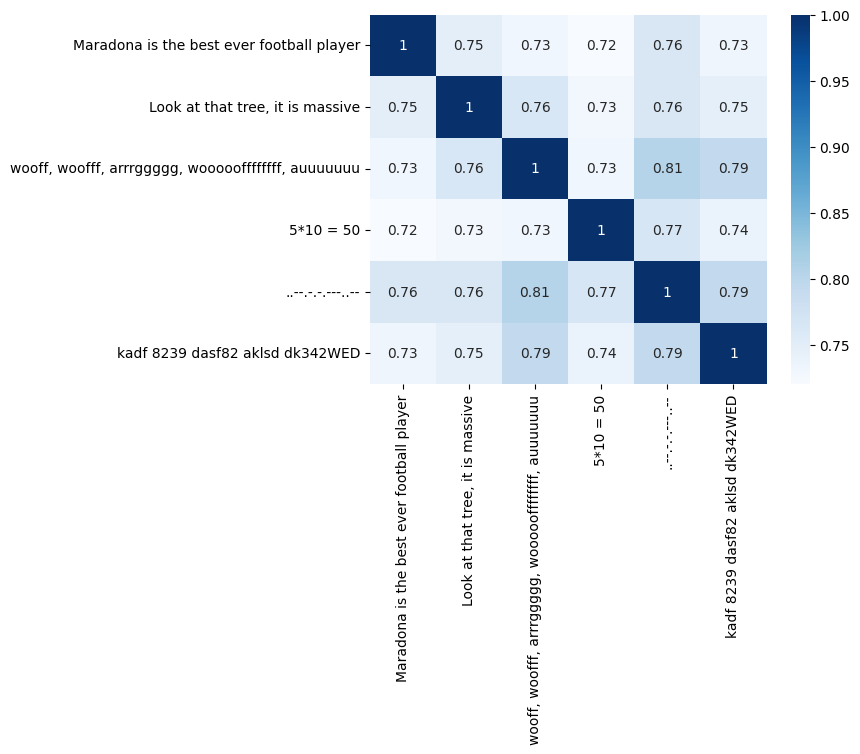

In [6]:
random_sentences = ["Maradona is the best ever football player", 
                    "Look at that tree, it is massive", 
                    "wooff, woofff, arrrggggg, woooooffffffff, auuuuuuu",   #dog language
                    "5*10 = 50", 
                    "..--.-.-.---..--",
                    "kadf 8239 dasf82 aklsd dk342WED"]

calculate_and_plot(random_sentences)

**Discusion point** What do you think about the distances? 

# Embedding search (aka Vector search). The RA in RAG

## In the land of Mordor...

In [7]:
# Facts generated by ChatGPT

tower_of_mordor_facts = [
    "The Tower of Mordor, also known as Barad-dûr, is the fortress of Sauron in J.R.R. Tolkien's Middle-earth.",
    "Barad-dûr is located in the land of Mordor, east of Gondor and near Mount Doom.",
    "The tower was built by Sauron during the Second Age, starting around 1000 S.A.",
    "Construction of Barad-dûr took nearly 600 years to complete.",
    "Barad-dûr was partly destroyed at the end of the Second Age when the Last Alliance of Elves and Men defeated Sauron.",
    "The tower was rebuilt during the Third Age when Sauron regained power.",
    "Barad-dûr's foundations were intertwined with the power of the One Ring, making it indestructible as long as the Ring existed.",
    "The tower stood over 4,500 feet tall, making it one of the tallest structures in Middle-earth.",
    "Barad-dûr is described as a dark, menacing fortress with iron gates and battlements.",
    "The Eye of Sauron, a fiery, lidless eye, was a symbol of Sauron's vigilance and power, often depicted as being atop Barad-dûr.",
    "Barad-dûr had numerous orcs, trolls, and other dark creatures as its inhabitants and guards.",
    "The tower featured extensive dungeons and torture chambers where prisoners were kept and interrogated.",
    "Barad-dûr's architecture was marked by sharp angles, black stone, and a foreboding presence.",
    "From Barad-dûr, Sauron could survey much of Middle-earth and command his armies.",
    "The fortress was surrounded by the desolate, ashen plains of Gorgoroth.",
    "During the War of the Ring, Barad-dûr served as the command center for Sauron's military campaigns.",
    "The destruction of the One Ring by Frodo Baggins led to the ultimate downfall of Barad-dûr, which collapsed entirely in the ensuing cataclysm.",
    "Barad-dûr was also known as the Dark Tower, symbolizing its role as a bastion of evil in Middle-earth.",
    "The tower's construction involved the use of dark magic and the enslavement of countless laborers.",
    "Barad-dûr's fall marked the end of Sauron's dominion and the beginning of the Fourth Age of Middle-earth."
]

mordor_facts = [
    "Mordor is located in the southeast of Middle-earth, bordered by the Ered Lithui (Ash Mountains) to the north and the Ephel Dúath (Mountains of Shadow) to the west and south.",
    "Mordor is ruled by the Dark Lord Sauron, who seeks to dominate all of Middle-earth.",
    "Sauron's fortress, Barad-dûr (the Dark Tower), is located in Mordor. It is a massive structure, nearly impregnable.",
    "Orodruin, or Mount Doom, is the volcano in Mordor where the One Ring was forged and is the only place where it can be destroyed.",
    "The main entrance to Mordor is the Black Gate (Morannon), a massive fortified gateway in the northwest.",
    "Formerly known as Minas Ithil, this city was captured by Sauron's forces and became a base for the Nazgûl, the Ringwraiths.",
    "Mordor is the home base for the Ringwraiths, Sauron's most fearsome servants.",
    "Sauron manifests as a fiery, lidless eye that constantly watches over Mordor and beyond from the top of Barad-dûr.",
    "A pass into Mordor guarded by the Tower of Cirith Ungol, infested with Orcs and the giant spider Shelob.",
    "This barren, desolate plateau lies in the heart of Mordor and is the location of Mount Doom.",
    "The southern part of Mordor, less barren and home to the inland Sea of Núrn, which supports the agriculture that feeds Sauron's armies.",
    "Mordor is filled with industrial facilities for the mass production of weapons and armor, particularly for its Orc armies.",
    "Many of the inhabitants of Núrn are slaves, captured from other lands and forced to work for Sauron's war effort.",
    "Located north of Mordor, these marshes are filled with the bodies of those who died in the Battle of Dagorlad.",
    "Mordor is a place of constant fear and dread, where even Sauron's own servants are not safe from his wrath.",
    "The skies of Mordor are often filled with ash and smoke from Mount Doom, casting a perpetual gloom over the land.",
    "Although primarily associated with Saruman, many of the Uruk-hai also serve Sauron in Mordor.",
    "The Black Speech, created by Sauron, is spoken in Mordor. The inscription on the One Ring is in this language.",
    "A symbol of Sauron's vigilance and control, the Great Eye is often used as a symbol of fear in Mordor.",
    "Provides the water necessary for the limited agriculture in Núrn, crucial for feeding Sauron's vast armies.",
    "A valley near Mount Doom, used for the smelting and forging of weapons.",
    "Mordor is a region of intense geothermal activity, with many volcanoes and lava flows besides Mount Doom.",
    "Mordor was chosen by Sauron as his base of operations during the Second Age, after the downfall of Númenor.",
    "Mordor's climate is harsh, with very little rainfall and frequent volcanic activity.",
    "Shelob, a giant spider, resides in Cirith Ungol and is a deadly guardian of one of the entrances to Mordor.",
    "Mordor served as the staging ground for Sauron's siege against Gondor, particularly during the Battle of the Pelennor Fields.",
    "Mordor is roughly 350 miles from west to east and 450 miles from north to south, a vast region of desolation and terror.",
    "There are several secret ways into Mordor, such as the pass of Cirith Ungol, used by Frodo and Sam.",
    "The symbol of Sauron's Eye is ubiquitous throughout Mordor, representing his omnipresence and power.",
    "In Tolkien's legendarium, Mordor epitomizes the ultimate manifestation of evil, oppression, and darkness."
]

about_mordor = tower_of_mordor_facts + mordor_facts

In [8]:
calculate_and_short("How big is mordor?", about_mordor)[:1]

,How big is mordor?
"Mordor is roughly 350 miles from west to east and 450 miles from north to south, a vast region of desolation and terror.",0.880308


In [9]:
calculate_and_short("What are the square miles of mordor?", about_mordor)[:1]

,What are the square miles of mordor?
"Mordor is roughly 350 miles from west to east and 450 miles from north to south, a vast region of desolation and terror.",0.882264


In [10]:
calculate_and_short("Is it safe to build a nuclear power plant in mordor?", about_mordor)[:1]

,Is it safe to build a nuclear power plant in mordor?
"Mordor is filled with industrial facilities for the mass production of weapons and armor, particularly for its Orc armies.",0.831105


In [11]:
calculate_and_short("Is it safe to build a nuclear power plant in mordor?", about_mordor)[:3]

,Is it safe to build a nuclear power plant in mordor?
"Mordor is filled with industrial facilities for the mass production of weapons and armor, particularly for its Orc armies.",0.831105
"Mordor is a place of constant fear and dread, where even Sauron's own servants are not safe from his wrath.",0.824417
"Mordor is a region of intense geothermal activity, with many volcanoes and lava flows besides Mount Doom.",0.822392


**Discussion** around safety of mordor for building a nuclear power plant**

#### More difficult questions

In [12]:
calculate_and_short("What is the tallest tower in mordor", about_mordor)[:3]

,What is the tallest tower in mordor
"The tower stood over 4,500 feet tall, making it one of the tallest structures in Middle-earth.",0.878891
"The Tower of Mordor, also known as Barad-dûr, is the fortress of Sauron in J.R.R. Tolkien's Middle-earth.",0.874270
"Sauron's fortress, Barad-dûr (the Dark Tower), is located in Mordor. It is a massive structure, nearly impregnable.",0.848775


## Noise

In [13]:
eiffel_tower_facts = [
    "The Eiffel Tower was completed in 1889 for the Exposition Universelle (World's Fair) to celebrate the 100th anniversary of the French Revolution.",
    "It was designed by the French engineer Gustave Eiffel, although the initial design was created by Maurice Koechlin and Émile Nouguier.",
    "Originally, the Eiffel Tower stood at 300 meters (984 feet) tall. With the addition of antennas, it is now approximately 324 meters (1,063 feet) tall.",
    "The tower is made of iron and weighs about 10,100 tons.",
    "The Eiffel Tower is repainted every seven years to protect it from rust. This requires about 60 tons of paint.",
    "It took two years, two months, and five days to build, with construction starting in January 1887 and completing in March 1889.",
    "It is one of the most visited paid monuments in the world, with nearly 7 million visitors annually.",
    "When it was first built, many Parisians and artists criticized the Eiffel Tower, calling it an eyesore.",
    "During World War II, the lift cables were cut, and the tower was closed to the public. The French cut the cables to prevent Hitler from using the elevator to reach the top.",
    "The Eiffel Tower has been used as a radio transmission tower since 1910 and later for television broadcasting.",
    "The tower sways slightly in the wind. It can sway about 6 to 7 centimeters (2 to 3 inches) in strong winds.",
    "The iron expands and contracts with temperature changes. On hot days, the tower can grow about 15 centimeters (6 inches).",
    "The tower is illuminated every evening, and since 1985, it has featured a sparkling light show every hour on the hour after dusk.",
    "There are two restaurants in the Eiffel Tower: Le 58 Tour Eiffel on the first floor and the Michelin-starred Le Jules Verne on the second floor.",
    "The Eiffel Tower influenced numerous structures worldwide, including the Tokyo Tower in Japan and the Blackpool Tower in England.",
    "It has appeared in numerous films, books, and artworks, becoming an enduring symbol of France and Paris.",
    "Over 1,500 sets of stairs are used for maintenance and inspections of the tower.",
    "The Eiffel Tower is painted in three shades of brown, with the darkest shade at the bottom and the lightest at the top to enhance its silhouette against the sky.",
    "The Eiffel Tower is owned by the City of Paris and operated by a development company (Société d'Exploitation de la Tour Eiffel).",
    "The Eiffel Tower often changes its lighting and color schemes for special occasions, such as national holidays, significant events, and global causes."
]

big_ben_facts = [
    "Big Ben is the nickname for the Great Bell of the clock at the north end of the Palace of Westminster in London, but it is often extended to refer to the clock and the clock tower.",
    "The tower was completed in 1859 and is part of the design by Charles Barry for the new Palace of Westminster after the old palace was destroyed by fire in 1834.",
    "The official name of the tower was originally the Clock Tower, but it was renamed Elizabeth Tower in 2012 to mark the Diamond Jubilee of Queen Elizabeth II.",
    "The clock tower stands at 96 meters (315 feet) tall.",
    "Big Ben is the largest of the five bells in the tower and weighs 13.7 tons (13,760 kg).",
    "The clock is one of the most accurate mechanical clocks in the world, designed by Edmund Beckett Denison and George Airy.",
    "Each clock face is 7 meters (23 feet) in diameter.",
    "The minute hands are 4.2 meters (14 feet) long and weigh about 100 kilograms (220 pounds).",
    "The clock started ticking on 31 May 1859, and Big Ben first chimed on 11 July 1859.",
    "The tower leans slightly to the northwest, by approximately 0.26 degrees, due to ground conditions.",
    "Big Ben's clock mechanism is manually wound three times a week.",
    "The clock tower survived bombing raids during World War II, despite the nearby House of Commons being destroyed.",
    "The chimes of Big Ben are broadcast live by the BBC, a tradition that started on 31 December 1923.",
    "The clock has stopped several times, including during maintenance work and extreme weather conditions.",
    "The bell cracked during testing in October 1857 and had to be recast. It cracked again in 1859, but the crack was turned to avoid further damage, giving Big Ben its distinctive sound.",
    "There are 334 steps to the belfry, the top of the tower.",
    "The clock faces are cleaned by a specialist team of abseilers once every five years.",
    "The Latin inscription around the base of each clock face reads 'DOMINE SALVAM FAC REGINAM NOSTRAM VICTORIAM PRIMAM,' which means 'O Lord, keep safe our Queen Victoria the First.'",
    "In 2021, the Elizabeth Tower underwent its biggest renovation in 40 years, including new paint, glass, and repairs to the masonry.",
    "The clock tower is part of the UNESCO World Heritage Site of the Palace of Westminster and Westminster Abbey, including Saint Margaret's Church."
]

lots_of_data = eiffel_tower_facts + big_ben_facts + about_mordor

In [14]:

calculate_and_short("What is tower took the most time to be built?", lots_of_data)[:3]

,What is tower took the most time to be built?
"The tower is made of iron and weighs about 10,100 tons.",0.842748
The clock tower stands at 96 meters (315 feet) tall.,0.829652
The tower's construction involved the use of dark magic and the enslavement of countless laborers.,0.828528


In [15]:
calculate_and_short("Which building took the most time to be built?", lots_of_data)[:3]

,Which building took the most time to be built?
"It took two years, two months, and five days to build, with construction starting in January 1887 and completing in March 1889.",0.850867
Construction of Barad-dûr took nearly 600 years to complete.,0.819647
The tower was completed in 1859 and is part of the design by Charles Barry for the new Palace of Westminster after the old palace was destroyed by fire in 1834.,0.803637


In [16]:
calculate_and_short("What tower took the most of the time to be completed?", lots_of_data)[:5]

# The right answer is "Construction of Barad-dûr took nearly 600 years to complete."

,What tower took the most of the time to be completed?
The clock tower stands at 96 meters (315 feet) tall.,0.832500
"The tower is made of iron and weighs about 10,100 tons.",0.825937
"The official name of the tower was originally the Clock Tower, but it was renamed Elizabeth Tower in 2012 to mark the Diamond Jubilee of Queen Elizabeth II.",0.824796
"In 2021, the Elizabeth Tower underwent its biggest renovation in 40 years, including new paint, glass, and repairs to the masonry.",0.820175
"The tower stood over 4,500 feet tall, making it one of the tallest structures in Middle-earth.",0.816451


**Discussion point**: Effect of how you formulate the question in the retrieval.

In [17]:
calculate_and_short("What took the most of the time to be completed?", lots_of_data)[:5]



,What took the most of the time to be completed?
"It took two years, two months, and five days to build, with construction starting in January 1887 and completing in March 1889.",0.814457
Construction of Barad-dûr took nearly 600 years to complete.,0.806429
"The clock started ticking on 31 May 1859, and Big Ben first chimed on 11 July 1859.",0.771651
The tower's construction involved the use of dark magic and the enslavement of countless laborers.,0.769482
"The clock has stopped several times, including during maintenance work and extreme weather conditions.",0.767046


In [18]:
calculate_and_short("Barad-dûr", ["tower","construction"])[:5]

,Barad-dûr
tower,0.793486
construction,0.761482


**Discussion**. We can see the effect of the training corpus in the distances. It seems that our embeddings are not aware that Barad-dur is a tower. Let's compare with Eiffel

In [19]:
calculate_and_short("Eiffel", ["tower","construction"])[:5]

,Eiffel
tower,0.832196
construction,0.794167


# Other interesting cases

### Similarity with familiar expressions that mean the same

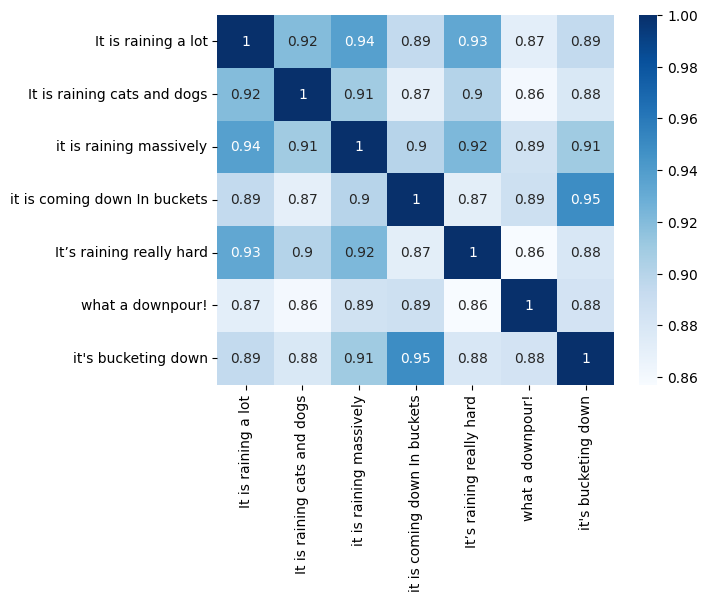

In [20]:
calculate_and_plot(["It is raining a lot", 
                    "It is raining cats and dogs", 
                    "it is raining massively", 
                    "it is coming down In buckets",
                    "It’s raining really hard",
                    "what a downpour!",
                    "it's bucketing down"])

### Similarity with  expressions that mean the same in different languages

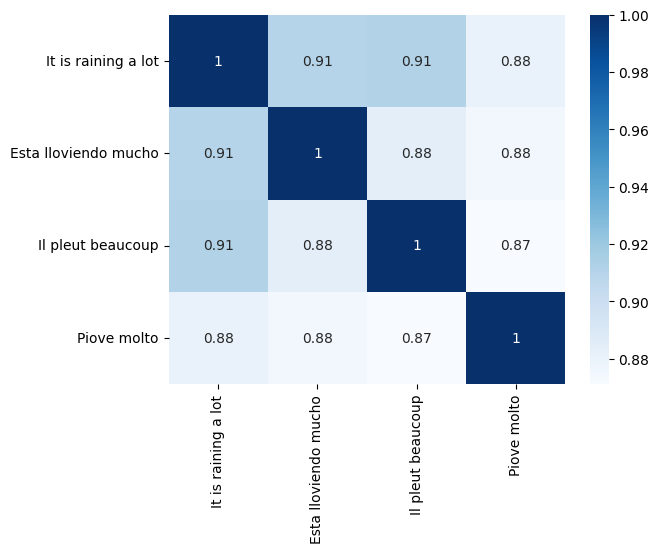

In [21]:
calculate_and_plot(["It is raining a lot", 
                    "Esta lloviendo mucho", 
                    "Il pleut beaucoup", 
                    "Piove molto"])

### Similarity with puntuation errors

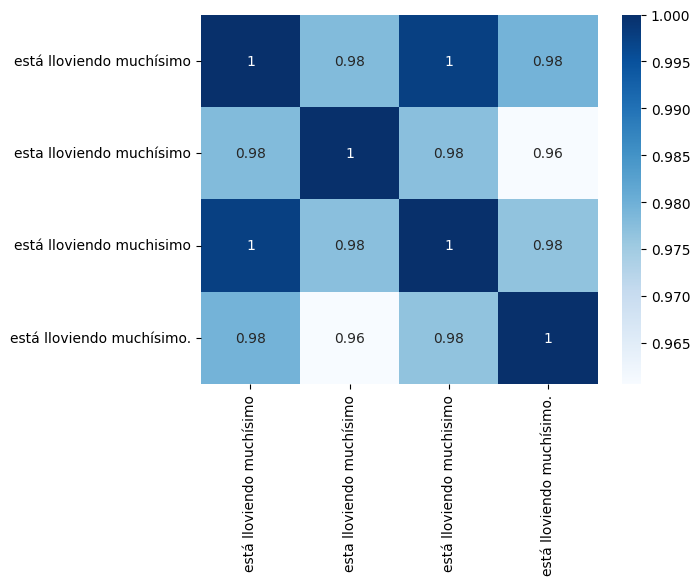

In [22]:
calculate_and_plot(["está lloviendo muchísimo", 
                    "esta lloviendo muchísimo", 
                    "está lloviendo muchisimo", 
                    "está lloviendo muchísimo."])

### Similarity wit opposites



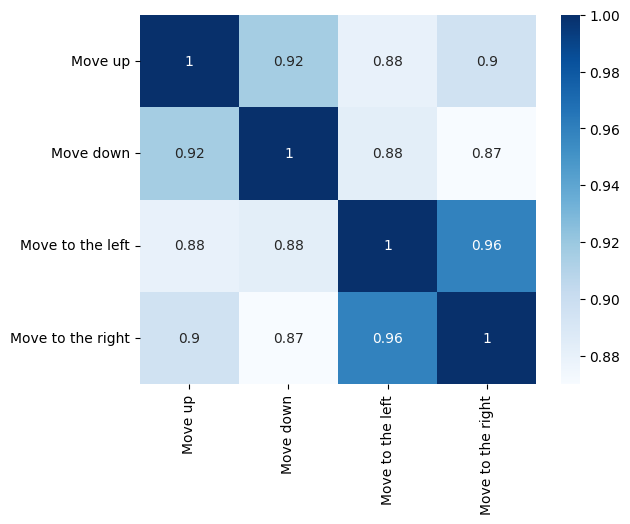

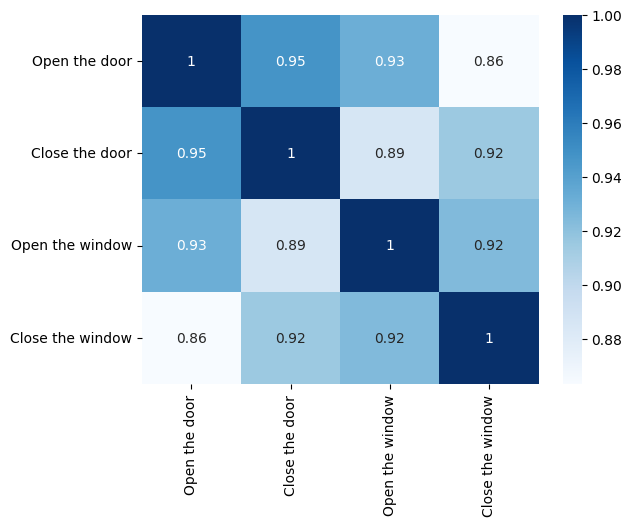

In [23]:
### Similarity wit opposites

calculate_and_plot(["Move up", 
                    "Move down", 
                    "Move to the left", 
                    "Move to the right"])

calculate_and_plot(["Open the door", 
                    "Close the door", 
                    "Open the window", 
                    "Close the window"])